In [1]:
import numpy as np
import pandas as pd
from math import log

In [2]:
df = pd.read_csv('./example_data.csv', dtype={'windy': 'str'})
df

,humility,outlook,play,temp,windy
0,high,sunny,no,hot,false
1,high,sunny,no,hot,true
2,high,overcast,yes,hot,false
3,high,rainy,yes,mild,false
4,normal,rainy,yes,cool,false
5,normal,rainy,no,cool,true
6,normal,overcast,yes,cool,true
7,high,sunny,no,mild,false
8,normal,sunny,yes,cool,false
9,normal,rainy,yes,mild,false


In [3]:
def entropy(ele):
    probs = [ele.count(i)/len(ele) for i in set(ele)]
    entropy = -sum([prob*log(prob, 2) for prob in probs])
    return entropy

In [4]:
entropy(df['play'].tolist())

0.9402859586706309

In [5]:
def split_dataframe(data, col):
    unique_values = data[col].unique()
    result_dict = {elem : pd.DataFrame for elem in unique_values}
    for key in result_dict.keys():
        result_dict[key] = data[:][data[col] == key]
    return result_dict

split_example = split_dataframe(df, 'temp')

In [6]:
for item, value in split_example.items():
    print(item, value)

hot    humility   outlook play temp  windy
0      high     sunny   no  hot  false
1      high     sunny   no  hot   true
2      high  overcast  yes  hot  false
12   normal  overcast  yes  hot  false
mild    humility   outlook play  temp  windy
3      high     rainy  yes  mild  false
7      high     sunny   no  mild  false
9    normal     rainy  yes  mild  false
10   normal     sunny  yes  mild   true
11     high  overcast  yes  mild   true
13     high     rainy   no  mild   true
cool   humility   outlook play  temp  windy
4   normal     rainy  yes  cool  false
5   normal     rainy   no  cool   true
6   normal  overcast  yes  cool   true
8   normal     sunny  yes  cool  false


In [7]:
def choose_best_col(df, label):
    entropy_D = entropy(df[label].tolist())
    cols = [col for col in df.columns if col not in [label]]
    max_value, best_col = -999, None
    max_splited = None
    for col in cols:
        splited_set = split_dataframe(df, col)
        entropy_DA = 0
        for subset_col, subset in splited_set.items():
            entropy_Di = entropy(subset[label].tolist())
            entropy_DA += len(subset)/len(df) * entropy_Di
        info_gain = entropy_D - entropy_DA
        
        if info_gain > max_value:
            max_value, best_col = info_gain, col
            max_splited = splited_set
    return max_value, best_col, max_splited
    
choose_best_col(df, 'play')

(0.2467498197744391,
 'outlook',
 {'sunny':    humility outlook play  temp  windy
  0      high   sunny   no   hot  false
  1      high   sunny   no   hot   true
  7      high   sunny   no  mild  false
  8    normal   sunny  yes  cool  false
  10   normal   sunny  yes  mild   true,
  'overcast':    humility   outlook play  temp  windy
  2      high  overcast  yes   hot  false
  6    normal  overcast  yes  cool   true
  11     high  overcast  yes  mild   true
  12   normal  overcast  yes   hot  false,
  'rainy':    humility outlook play  temp  windy
  3      high   rainy  yes  mild  false
  4    normal   rainy  yes  cool  false
  5    normal   rainy   no  cool   true
  9    normal   rainy  yes  mild  false
  13     high   rainy   no  mild   true})

In [8]:
class ID3Tree:
    class Node:
        def __init__(self, name):
            self.name = name
            self.connections = {}

        def connect(self, label, node):
            self.connections[label] = node
            
    def __init__(self, data, label):
        self.columns = data.columns
        self.data = data
        self.label = label
        self.root = self.Node("Root")
        
    def print_tree(self, node, tabs):
        print(tabs + node.name)
        for connection, child_node in node.connections.items():
            print(tabs + "\t" + "(" + connection + ")")
            self.print_tree(child_node, tabs + "\t\t")

    def construct_tree(self):
        self.construct(self.root, "", self.data, self.columns)
        
    def construct(self, parent_node, parent_connection_label, input_data, columns):
        max_value, best_col, max_splited = choose_best_col(input_data[columns], self.label)
        
        if not best_col:
            node = self.Node(input_data[self.label].iloc[0])
            parent_node.connect(parent_connection_label, node)
            return

        node = self.Node(best_col)
        parent_node.connect(parent_connection_label, node)
        
        new_columns = [col for col in columns if col != best_col]
        
        for splited_value, splited_data in max_splited.items():
            self.construct(node, splited_value, splited_data, new_columns)

In [9]:
tree1 = ID3Tree(df, 'play')
tree1.construct_tree()

In [10]:
tree1.print_tree(tree1.root, "")

Root
	()
		outlook
			(sunny)
				humility
					(high)
						temp
							(hot)
								windy
									(false)
										no
									(true)
										no
							(mild)
								windy
									(false)
										no
					(normal)
						temp
							(cool)
								windy
									(false)
										yes
							(mild)
								windy
									(true)
										yes
			(overcast)
				humility
					(high)
						temp
							(hot)
								windy
									(false)
										yes
							(mild)
								windy
									(true)
										yes
					(normal)
						temp
							(cool)
								windy
									(true)
										yes
							(hot)
								windy
									(false)
										yes
			(rainy)
				windy
					(false)
						humility
							(high)
								temp
									(mild)
										yes
							(normal)
								temp
									(cool)
										yes
									(mild)
										yes
					(true)
						humility
							(normal)
								temp
									(cool)
										no
							(high)
								temp
									(mild)
										no


In [11]:
from sklearn import tree
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
clf.predict([[2, 2]])

array([1])

In [12]:
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
clf = clf.fit(iris.data, iris.target)

In [13]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render('iris')

'iris.pdf'

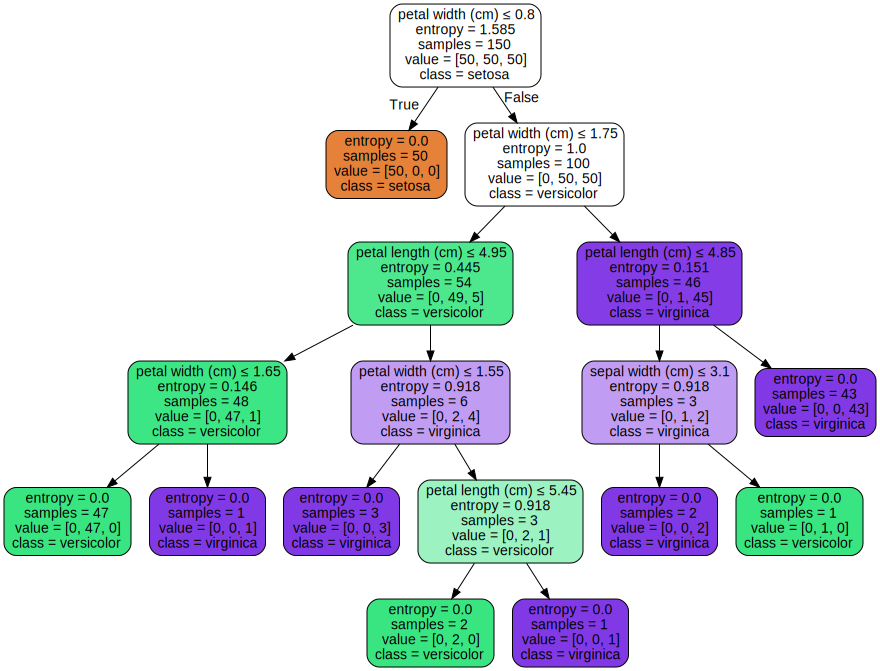

In [14]:
dot_data = tree.export_graphviz(clf, out_file=None,
                               feature_names=iris.feature_names,
                               class_names=iris.target_names,
                               filled=True, 
                               rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph